In [1]:
import os
import random
import time

import numpy as np
import torch
from absl import app
# from klearn_tcyclone.training_utils.args import FLAGS, ALL_FLAGS
from klearn_tcyclone.training_utils.training_utils import get_default_flag_values
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils import data

from klearn_tcyclone.climada.tc_tracks import TCTracks
from klearn_tcyclone.data_utils import (
    LinearScaler,
)
from klearn_tcyclone.KNF.modules.eval_metrics import RMSE_TCTracks
from klearn_tcyclone.KNF.modules.models import Koopman
from klearn_tcyclone.KNF.modules.train_utils import (
    eval_epoch_koopman,
    train_epoch_koopman,
)
from klearn_tcyclone.knf_data_utils import TCTrackDataset
from klearn_tcyclone.training_utils.training_utils import set_flags
from absl import app, flags

In [2]:
from klearn_tcyclone.training_utils.training_utils import extend_by_default_flag_values

In [3]:
loss_fun = nn.MSELoss()

Set some specific parameters and load default values for all other parameters.

In [4]:
flag_params = {
    # "seed": 42,
    # "year_range": [1980, 1988],
    # "batch_size": 16,
    "num_epochs": 2,
}
flag_params = extend_by_default_flag_values(flag_params)

In [36]:
# seed = flag_dict["seed"]
# model_str = flag_dict["model"]
# dataset = flag_dict["dataset"]
# year_range = flag_dict["year_range"]
# global_local_combination = flag_dict["global_local_combination"]
# learning_rate = flag_dict["learning_rate"]
# decay_rate = flag_dict["decay_rate"]
# batch_size = flag_dict["batch_size"]
# num_epochs = flag_dict["num_epochs"]
# min_epochs = flag_dict["min_epochs"]

# feature_list = ["lat", "lon"]
# # feature_list = ["lat", "lon", "central_pressure"]

# # fixed parameters
# train_output_length = 15
# hidden_dim = 128
# num_layers = 4
# input_dim = 3
# parameter_dict = {
#     # fixed parameters
#     "freq": None,
#     "num_feats": len(feature_list),
#     "train_output_length": train_output_length,
#     "input_dim": input_dim,
#     "input_length": 21,
    
#     "latent_dim": 32,
#     "num_layers": num_layers,
#     "control_num_layers": 3,
#     "control_hidden_dim": 64,
#     "transformer_dim": 64,
#     "transformer_num_layers": 3,
#     "test_output_length": train_output_length,
#     # num_steps can be chosen differently to train_output_length.
#     "num_steps": 15,
#     "jumps": 2,

#     "hidden_dim": hidden_dim,
#     "control_hidden_dim": 64,
#     # "hidden_dim": num_feats,
#     # "control_hidden_dim": hidden_dim,

#     "encoder_hidden_dim": hidden_dim,
#     "decoder_hidden_dim": hidden_dim,
#     "encoder_num_layers": num_layers,
#     "decoder_num_layers": num_layers,
#     "output_dim": input_dim,
#     "use_revin": True,
#     "use_instancenorm": False,
#     # "use_instancenorm": True,
#     "regularize_rank": False,
#     "add_global_operator": True,
#     "add_control": True,
#     "num_sins": -1,
#     "num_poly": -1,
#     "num_exp": -1,
#     "num_heads": 1,
#     "dropout_rate": 0,
# }
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Device", device)

In [37]:
random.seed(flag_params["seed"])  # python random generator
np.random.seed(flag_params["seed"])  # numpy random generator

torch.manual_seed(flag_params["seed"])
torch.cuda.manual_seed_all(flag_params["seed"])

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

feature_list = ["lat", "lon"]
# feature_list = ["lat", "lon", "central_pressure"]

# these are not contained as flags
encoder_hidden_dim = flag_params["hidden_dim"]
decoder_hidden_dim = flag_params["hidden_dim"]
encoder_num_layers = flag_params["num_layers"]
decoder_num_layers = flag_params["num_layers"]
output_dim = flag_params["input_dim"]
num_feats = len(feature_list)
learning_rate = flag_params["learning_rate"]
# ---------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

scaler = LinearScaler()
eval_metric = RMSE_TCTracks

Device cuda


In [38]:
# Datasets
tc_tracks = TCTracks.from_ibtracs_netcdf(
    provider="usa",
    year_range=flag_params["year_range"],
    basin="NA",
    correct_pres=False,
)

tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)
train_set = TCTrackDataset(
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
    tc_tracks=tc_tracks_train,
    feature_list=feature_list,
    mode="train",
    jumps=flag_params["jumps"],
    scaler=scaler,
    fit=True,
)
valid_set = TCTrackDataset(
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
    tc_tracks=tc_tracks_train,
    feature_list=feature_list,
    mode="valid",
    jumps=flag_params["jumps"],
    scaler=scaler,
    fit=False,
)
test_set = TCTrackDataset(
    input_length=flag_params["input_length"],
    output_length=flag_params["test_output_length"],
    tc_tracks=tc_tracks_test,
    feature_list=feature_list,
    mode="test",
    # jumps=flag_params["jumps"], # jumps not used in test mode
    scaler=scaler,
    fit=False,
)
train_loader = data.DataLoader(
    train_set, batch_size=flag_params["batch_size"], shuffle=True, num_workers=1
)
valid_loader = data.DataLoader(
    valid_set, batch_size=flag_params["batch_size"], shuffle=True, num_workers=1
)
test_loader = data.DataLoader(
    test_set, batch_size=flag_params["batch_size"], shuffle=False, num_workers=1
)

if len(train_loader) == 0:
    raise Exception(
        "There are likely too few data points in the test set. Try to increase year_range."
    )

2024-10-10 19:27:58,530 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-10-10 19:28:00,076 - climada.hazard.tc_tracks - WARNING - 4 storm events are discarded because no valid wind/pressure values have been found: 1990145N19276, 1990262N15315, 1991187N23264, 1991241N11329.


c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


In [39]:
flag_params["data_freq"]

'None'

In [40]:
os.getcwd()

'c:\\Users\\Eric\\Projects\\koopman_learning_tropical_cyclone\\examples'

In [41]:
model_folder_path = (
    "Koopman_"
    + str(flag_params["dataset"])
    + "_model{}_glc{}".format(flag_params["model"], flag_params["global_local_combination"])
)
model_name = (
    "seed{}_jumps{}_freq{}_poly{}_sin{}_exp{}_bz{}_lr{}_decay{}_dim{}_inp{}_pred{}_num{}_enchid{}_dechid{}_trm{}_conhid{}_enclys{}_declys{}_trmlys{}_conlys{}_latdim{}_RevIN{}_insnorm{}_regrank{}_globalK{}_contK{}".format(  # noqa: E501, UP032
        flag_params["seed"],
        flag_params["jumps"],
        flag_params["data_freq"],
        flag_params["num_poly"],
        flag_params["num_sins"],
        flag_params["num_exp"],
        flag_params["batch_size"],
        flag_params["learning_rate"],
        flag_params["decay_rate"],
        flag_params["input_dim"],
        flag_params["input_length"],
        flag_params["train_output_length"],
        flag_params["num_steps"],
        encoder_hidden_dim,
        decoder_hidden_dim,
        flag_params["transformer_dim"],
        flag_params["control_hidden_dim"],
        encoder_num_layers,
        decoder_num_layers,
        flag_params["transformer_num_layers"],
        flag_params["control_num_layers"],
        flag_params["latent_dim"],
        flag_params["use_revin"],
        flag_params["use_instancenorm"],
        flag_params["regularize_rank"],
        flag_params["add_global_operator"],
        flag_params["add_control"],
    )
)

file_dir_path = os.getcwd()
root_path = os.path.join(file_dir_path, "../")
results_dir = os.path.join(
    root_path,
    "train_models",
    "training_results",
    flag_params["dataset"],
    model_folder_path,
)

Load model and evaluation scores

In [42]:
file_name_model = os.path.join(results_dir, model_name + ".pth")
[best_model, epoch, learning_rate] = torch.load(
    file_name_model,
)

res_dicts = []
for epoch in range(0, flag_params["num_epochs"]):
    # load test scores.
    file_name_test_model = os.path.join(results_dir, f"ep{epoch}_test" + model_name + ".pt")
    res_dicts.append(torch.load(
        file_name_test_model,
    ))

eval_scores = np.array([
    res_dict["eval_score"] for res_dict in res_dicts
])

file_name_test_model = os.path.join(results_dir, "test_" + model_name + ".pt")
test_eval_dict = torch.load(
    file_name_test_model,
)

C:\Users\Eric\AppData\Local\Temp\ipykernel_19644\2993641039.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  [best_model, epoch, learning_rate] = torch.load(
C:\Users\Eri

In [43]:
_, test_preds, test_tgts = eval_epoch_koopman(test_loader, best_model, loss_fun)
print(test_eval_dict["eval_score"], eval_metric(test_preds, test_tgts))

c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


(0.035451595, 0.052750442, 0.07553796, 0.059111934) (0.03562394, 0.05284494, 0.0754363, 0.059116416)


In [22]:
from matplotlib import pyplot as plt

In [24]:
epochs = list(range(0, num_epochs))

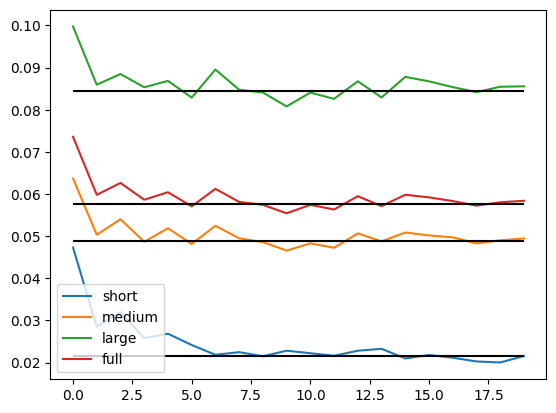

In [25]:
plt.plot(epochs, eval_scores[:, 0], label="short")
plt.plot(epochs, eval_scores[:, 1], label="medium")
plt.plot(epochs, eval_scores[:, 2], label="large")
plt.plot(epochs, eval_scores[:, 3], label="full")
plt.hlines(test_eval_dict["eval_score"], epochs[0], epochs[-1], colors="black")
plt.legend()